<a href="https://colab.research.google.com/github/zidane-dev/Machine-Learning-Collection/blob/master/TD3_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MOD 4.6 - TD 3 :  **Sequence-to-sequence with RNN and Transformers**



## 1. Projet description


The project aims at exploring and comparing a traditional RNN with a Transformer model for a translation task. We will translate the parallel corpus [Tatoeba](https://tatoeba.org/fr) from English to French.

### 1.1 Sequence-to-Sequence introduction
- Typical sequence-to-sequence (seq2seq) models are encoder-decoder models, which usually consists of two parts, the encoder and decoder, respectively. These two parts can be implemented with recurrent neural network (RNN) or **transformer**, primarily to deal with input/output sequences of dynamic length.
- **Encoder** encodes a sequence of inputs, such as text, video or audio, into a single vector, which can be viewed as the abstractive representation of the inputs, containing information of the whole sequence.
- **Decoder** decodes the vector output of encoder one step at a time, until the final output sequence is complete. Every decoding step is affected by previous step(s). Generally, one would add "< BOS >" at the begining of the sequence to indicate start of decoding, and "< EOS >" at the end to indicate end of decoding.

![seq2seq](https://i.imgur.com/0zeDyuI.png)

### 1.2 Work Description
- English to French (traditional) Translation
  - Input: an English sentence         
  - Output: the French translation 

- **TODO**
    - Train a simple RNN seq2seq to achieve translation
    - Switch to transformer model to boost the performance
    

## 2. Working environment

### 2.1 Google colab

This project will be done by using a Jupyter notebook on the Google Colab platform. To import the notebook on Google Colab, follow these steps :
1. Open the following link : https://colab.research.google.com/ 

2. If a window opens itself : just go on the Import tab

3. Else : Click-on File > Import a notebook

4. Import the TD3-seq2seq.ipynb file

You need to change the type of execution :

Click on : “Runtime” → “Change runtime type” → “Hardware accelerator”. 

Then select "GPU".


**WARNING** : The free version of Google Collab offers limited GPU usage. So think twice before running your code or you will be forced to use CPUs, which will make your code run much slower.

### 2.2 Set up the environment 

Download and import required packages

In [16]:
!pip install torchmetrics
! python -m spacy download fr_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.4.0/fr_core_news_sm-3.4.0-py3-none-any.whl (16.3 MB)
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [17]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
import torch
import torch.nn as nn
from torch import optim
from torchmetrics import BLEUScore
import torch.nn.functional as F
import math
import torchtext
from torchtext.data import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
from torch import Tensor
import io
import time
from torchtext.data.utils import get_tokenizer
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)
from nltk.translate.bleu_score import sentence_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Fix random seed and start a CUDA session

In [18]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## 3. Dataset pre-processing for RNN 

### 3.1 Overview

The data set is composed of 135842 sentences in English and French. To ease the training we will select only the sentences with a maximum length of 15. The sen- tences are relatively simple with a English vocabulary size of 3281 and a French vocabulary size of 4971. Examples :

— I’m not old. → Je ne suis pas vieux. 

— You’re funny. → Vous etes marrant.



### 3.2 Download and extract data

In [19]:
!wget  https://download.pytorch.org/tutorial/data.zip

--2022-12-30 23:09:53--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.156.46.129, 108.156.46.30, 108.156.46.108, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.156.46.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  5.11MB/s    in 0.5s    

2022-12-30 23:09:54 (5.11 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [20]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [21]:
src_lang = 'fr'
tgt_lang = 'en'

### 3.3 Sentence preprocessing
#### 3.3.1 Indexing words

We will need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count which will be used to replace rare words later.

![preprocessing](https://pytorch.org/tutorials/_images/word-encoding.png)

The Lang class allows to create an index dictionary for each word given a set of vocabulary for a given language.


In [22]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

#### 3.3.2 From Unicode to ASCII and text normalization

The files are all in Unicode. Before creating the index dictionary, the input text must be formatted :

— Be converted to Ascii, see the function `unicodeToAscii`

— Be normalized, by being in lowercase, trimmed, and without non-letter characters.



In [23]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

### Read langs

In [24]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

#### 3.3.3  Sentences filtering

We will then filter the sentences to eliminate all examples with a length greater than 15, and keep those starting with predefined words see the variable `eng_prefixes`.

In [25]:
MAX_LENGTH = 15
MIN_LENGTH = 1

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        len(p[0].split(' ')) > MIN_LENGTH and \
        len(p[1].split(' ')) > MIN_LENGTH and \
        len(p[0].split('.')) == 2 and \
        len(p[1].split('.')) == 2 and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

#### 3.3.4  Run the pre-processing

The full process for preparing the data is:

+ Read text file and split into lines, split lines into pairs

+ Normalize text, filter by length and content

+ Make word lists from sentences in pairs

In [26]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs( lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# NOte: reverse == True
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 12371 sentence pairs
Counting words...
Counted words:
fra 4969
eng 3280
['vous etes tres elegants .', 'you re very stylish .']


### 3.4 Split the data set

**TODO** In the next cell, write a function to randomly assign 90% of the pairs to a training set and 10% of them to an evaluation set.

In [ ]:
# The pairs for the training are in a variable named pairs_train
# and for the the evaluation in a variable named pairs_test

split = 0.9
# split index
length_data = len(pairs)
split_index = length_data - round(split * length_data) 
# data shuffle
rand = np.random.permutation(np.arange(length_data))
data_rand = [pairs[i] for i in rand] 
# data split
pairs_train = pairs[split_index:]
pairs_test = pairs[:split_index]

print("Len train : ", len(pairs_train), "Len test : ", len(pairs_test) )

Len train :  11134 Len test :  1237


## 4.  RNN Model

### 4.1 Overview 

A Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent steps.

A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

![RNN_fig1](https://pytorch.org/tutorials/_images/seq2seq.png)


To improve upon this model we will use an attention mechanism, which lets the decoder learn to focus over a specific range of the input sequence.

Thus, the first experiments consist in training an RNN model to translate English into French. The model will be composed of an encoder, integrating 1 layer of 256 GRU cells. It feeds a decoder having the same architecture. Between the two modules, there is an attention layer allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs.

![RNN_fig2](https://partage.liris.cnrs.fr/index.php/s/abd8WjgDcdg9T36/preview)


<center> Figure 1 - A) Model overview. B) Detailed architecture. </center>


### 4.2 The encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

![RNN_encoder](https://pytorch.org/tutorials/_images/encoder-network.png) 

####4.2.1 GRU cells

**TODO** Explain what a GRU cell is using the figure below [Fig.2].

![GRU](https://partage.liris.cnrs.fr/index.php/s/DDHaH7EQ3yDAeET/preview)

<center>Figure 2 - Gated Recurrent Units architecture</center>

The GRU is comprised of two independent gates, the **update gate** controls which information is to be retained or added, while the **reset gate** determines *how much*.  
Bot the reset and update gates are calculated by a sigmoid of the input data and the previous hidden state.
To obtain the output and the next hidden state, the inverse of the selection gate (what should *not* be kept) is used along with the reset gate (how much should be forgotten) with the output of the previous hidden state.

+++

In [28]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 4.3 A decoder with attention 

As the encoder, the decoder is composed of a single layer of GRU cells.

Read carefully the paper [1], it is key for the next model.

If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

![attention](https://i.imgur.com/1152PYf.png) 

Calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

![attention2](https://pytorch.org/tutorials/_images/attention-decoder-network.png) 

<center>Figure 3 - Decoder with attention</center>

**TODO** Considering the encoder code, define this layer in the definition of the `AttnDecoderRNN` class, and call it correctly in the forward method of the same class.

**TODO** According to the previous diagram (Figure 3), complete the line 25 (`attn_applied`) of the class `AttnDecoderRNN`.

**TODO** According to the equation (1) of the paper [1], what plays the role of querry, key and value ?

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        # TODO 
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # TODO
        # hint: .unsqueeze(0)
        attn_applied = torch.bmm(
                          attn_weights.unsqueeze(0),
                          encoder_outputs.unsqueeze(0)
                        )

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        print(F.softmax(output))
        # TODO
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 4.4 Training and evaluation functions

It is time to load the set of functions in memory that will allow the RNN to train. 

#### 4.4.1 Preparing training data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [27]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#### 4.4.2 Training functions

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.


In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

**TODO** Define what the teacher forcing option is, and give the pros and cons of such an option.


---
The teacher forcing option toggles whether the next input of the hidden layer will be the real value (the *target*) or his own prediction.

Using teacher forcing helps the model "learn" faster, however since it has not learned "on its own", the model may show instabilities.





#### 4.4.3 Helper functions

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

+ Start a timer

+ Initialize optimizers and criterion

+ Create set of training pairs

+ Start empty losses array for plotting

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs_train))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    return plot_losses

#### 4.4.4 Plotting results


In [41]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

#### 4.4.5 Evaluation functions

In [42]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs_test)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
def evaluate_all_blue_scores(encoder, decoder):
    score = 0
    for i in range(len(pairs_test)):
        pair = random.choice(pairs_test)
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words[:-1])
        score += sentence_bleu([output_sentence.split(' ')], pair[1].split(' '), [(1./3., 1./3., 1./3.) ])
    print("The BLUE score on the test set is ", score/len(pairs_test))


**TODO** Explain what is the principle of Blue score and what is its limits.

BLEU scores is a metric that permits the evaluation of machine translation.  
To evaluate whether a predicted translation matches with target potential translations, we can count the n-grams, that is the group of n words which are next to each other and are correct.  
This is the principle behind the BLEU score evaluation, which is usually an average of four n-grams, from the unigram to the 4-gram.

The BLEU score metric however useful, does not consider meaning of words nor structure of sentences, it comes with a simple calculation and a useful score, but certainly not to guide the model generalize better.

### 4.5 Training and Evaluating


#### 4.5.1 Training

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

<ipython-input-29-96fe9c4e7873>:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(output))


Streaming output truncated to the last 5000 lines.
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1.]]], grad_fn=<SoftmaxBackward0>)
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 

<Figure size 432x288 with 0 Axes>

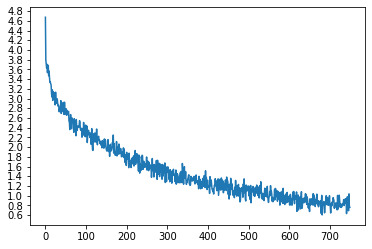

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

plot_losses = trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

#### 4.5.2 Evaluation

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> je suis tout a fait pret .
= i m all set .
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1

<ipython-input-29-96fe9c4e7873>:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(output))


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [ ]:
evaluate_all_blue_scores(encoder1, attn_decoder1)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

<ipython-input-29-96fe9c4e7873>:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(output))
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1.]]])
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

<ipython-input-29-96fe9c4e7873>:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(output))


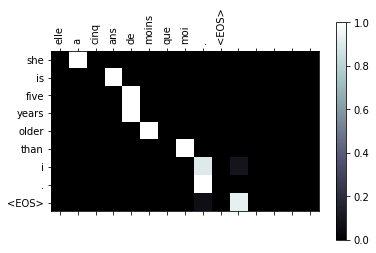

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")


## 5.  Transformer model for Translation

### 5.1 Pre-processing

A little more pre-processing must be done to adapt the data to a Transformer model. For this second model, the main difference lies in the use of torchtext.vocab objects to tokenize a raw text sentence and numericalize tokens into tensor. 

+ Split the data set into 3 sest, training, testing and validation.

In [29]:
fr_tokenizer = get_tokenizer('spacy', language='fr_core_news_sm')
en_tokenizer = get_tokenizer('basic_english')

range_pairs = range(len(pairs))
prop_train = 0.85
prop_val = 0.05
pairs_train = []
pairs_test = []
pairs_val = []
for i in range(len(pairs)):
    c_rand = random.random()
    if c_rand > prop_train + prop_val :
        pairs_test.append(pairs[i])
    elif c_rand > prop_train :
        pairs_val.append(pairs[i])
    else:
        pairs_train.append(pairs[i])  

print(len(pairs_train), len(pairs_test), len(pairs_val))

10516 1262 593


+ torchtext has utilities for creating datasets that can be easily iterated through for the purposes of creating a language translation model. In this example, we show how to tokenize a raw text sentence, build vocabulary, and numericalize tokens into tensor.



In [30]:
# Define special symbols and indices
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

def build_vocab(sets, tokenizer, lang):
    counter = Counter()
    if lang == 'fr':
        p_ind = 0
    else:
        p_ind = 1
    for split in sets:
        c_set = split
        for i in range(len(c_set)):
            c_paris = c_set[i][p_ind]
            for word in c_paris.split(' '):
                counter.update(tokenizer(word))
    return vocab(counter, specials=special_symbols)

fr_vocab = build_vocab([pairs_train, pairs_test, pairs_val ], fr_tokenizer, 'fr')
en_vocab = build_vocab([pairs_train, pairs_test, pairs_val ], en_tokenizer, 'en')

In [31]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def data_process(pair):
  data = []
  for (fr, en) in pair:
    fr_tensor_ = torch.tensor([fr_vocab[token] for token in fr_tokenizer(fr.rstrip("\n"))],
                            dtype=torch.long)
    en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(en.rstrip("\n"))],
                            dtype=torch.long)
    data.append((fr_tensor_, en_tensor_))
  return data

train_data = data_process(pairs_train)
val_data = data_process(pairs_val)
test_data = data_process(pairs_test)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

In [32]:
# print(pairs_train[0], pairs_train[0][0], pairs_train[0][1],)
# fr = pairs_train[0][0]
# en = pairs_train[0][1]
# tokens = fr_tokenizer(fr.rstrip("\n"))
# print(tokens)
# tokens2=[]
# for token in tokens :
#   print(token, ",",fr_vocab[token])
#   tokens2.append(fr_vocab[token])
# print(tokens2)
# torch.cat(torch.tensor([2]))


+ DataLoader


In [33]:
def generate_batch(data_batch):
  fr_batch, en_batch = [], []
  for (fr_item, en_item) in data_batch:
    fr_batch.append(torch.cat([torch.tensor([BOS_IDX]), fr_item, torch.tensor([EOS_IDX])]
    # , dim=0
    ))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])]
    # , dim=0
    ))
  fr_batch = pad_sequence(fr_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return en_batch, fr_batch


train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

### 5.2 Transformer overview

Transformer is a Seq2Seq model introduced in “Attention is all you need” paper for solving machine translation task. Transformer model consists of an encoder and decoder block each containing fixed number of layers.

Encoder processes the input sequence by propogating it, through a series of Multi-head Attention and Feed forward network layers. The output from the Encoder referred to as memory, is fed to the decoder along with target tensors. Encoder and decoder are trained in an end-to-end fashion using teacher forcing technique.

The core of Transformers is self-attention mechanisms. The main advantages of Transformer over compared to an RNN model are [2] :

— Parallel processing of all elements of the sequence, since it is not based on recurrent computation.

— It estimates the relevance of an element in relation to all other elements, by modeling the interactions of all entities in the sequence.

— Thus it takes into account the global information of a sequence.

![Transformers](https://partage.liris.cnrs.fr/index.php/s/FEadbZr6wSQEte9/preview)

<center>Figure 4 - Structure of Transformer (from [1])</center>


### 5.3 Self-Attention

**TODO** Describe the self-attention according to the paper "Attention is all you need" [1].

Self attention describes the mechanism which allows each token to justify its own representation by "paying attention" to the other tokens. It is different from *attention* by the fact that self attention happens only within a set of states ; attention of one state on the other states of its set. 

### 5.4 Multi-Head Attention

In order to encapsulate multiple relationships between the elements, *N* encoder and decoder modules are put in parallel [Fig.4, 5]. Defining *h* self-head attention blocks, each block owns a set of learnable weight matrix *{W<sup>Q,i</sup>,W<sup>K,i</sup>,W<sup>V,i</sup>}* where *i = 0, ...(h − 1)*. Like this, for an input *X* the outputs of the *h* self-attention blocks are concatenated into a single matrix *\[Z<sub>0</sub>, Z<sub>1</sub>, .., Z<sub>h−1</sub>\]* ∈ *R<sup>n×h.d<sub>v</sub></sup>* and projected on a weight matrix *W* ∈ *R<sup>h.d<sub>v</sub>×d</sup>*.

![MultiHeadAttention](https://partage.liris.cnrs.fr/index.php/s/s4GAM9P2NcyJw4B/preview)

<center>Figure 5 - Multi-Head Attention [1].</center>

### 5.5 Other key elements fo Transformer

#### 5.5.1 Positional embedding

To not consider the sequences like bags of words, words embedding are concatenated with their positional embedding vector [Fig.4]. Considering that each word is embedded into a vector of dimension *d<sub>m</sub>*, each element of the positional vector *POS* ∈ *R<sup>d</sup>* results from the following equation :

![equation](https://partage.liris.cnrs.fr/index.php/s/TpZPMCp7fERm22X/preview)

where *pos* is the integer corresponding to the word position in the sequence and *i* is the current entry in *POS*, the even and odd entry result respectively from (eq.1) and (eq.2).

#### 5.5.2 Residual connection and normalization layer

Residual connections and normalization layers are added to each sub-layer of the encoder-decoder module [Fig.4] such that :

![equation_layer_norm](https://partage.liris.cnrs.fr/index.php/s/7QJQigD7K8B5Ki6/preview)


#### 5.5.3 Feed-forward module

Multi-headed attention modules are tracked by feed-forward networks, consisting of two linear layers that are followed by a non-linear activation function [Fig.4] [3].

#### 5.5.4 Final layer of the decoder

To turn the stack of vectors back into a word, a linear layer projects the final vector into a logit vector of dimension *d<sub>vocab</sub>*. Then a softmax layer is used to turn the logits into probabilities [3].

### 5.6 Transformer encoder and decoder

**TODO** Complete the initialization of the `Seq2SeqTransformer` class by defining the decoder.

Then, load the model by running the code in following cells.

In [34]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int,
                 dim_feedforward:int = 512, dropout:float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        # TODO
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

Text tokens are represented by using token embeddings. Positional encoding is added to the token embedding to introduce a notion of word order.



In [35]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

We create a subsequent word mask to stop a target word from attending to its subsequent words. We also create masks, for masking source and target padding tokens

In [36]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

  src_padding_mask = (src == PAD_IDX).transpose(0, 1)
  tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

### 5.7  Training and evaluation functions for Transformer

**TODO** Complete the following training configuration by setting the variable `transformer` according to the definition of `Seq2SeqTransformer`. 

In [37]:
SRC_VOCAB = en_vocab
TGT_VOCAB = fr_vocab
TGT_VOCAB_SIZE = len(TGT_VOCAB)
SRC_VOCAB_SIZE = len(SRC_VOCAB)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 16

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# TODO
transformer = Seq2SeqTransformer( num_encoder_layers = NUM_ENCODER_LAYERS, 
                                  num_decoder_layers = NUM_DECODER_LAYERS,
                                  emb_size = EMB_SIZE, 
                                  src_vocab_size = SRC_VOCAB_SIZE, 
                                  tgt_vocab_size = TGT_VOCAB_SIZE,
                                  dim_feedforward = FFN_HID_DIM
                                 )

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

In [38]:
def train_epoch(model, train_iter, optimizer):
  model.train()
  losses = 0
  for idx, ( src ,tgt  ) in enumerate(train_iter):

      print(idx, ( src ,tgt  ))
      src = src.to(device)
      tgt = tgt.to(device)

      print(tgt)
      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

      logits = model(src, tgt_input, src_mask, tgt_mask,
                                src_padding_mask, tgt_padding_mask, src_padding_mask)

      optimizer.zero_grad()

      tgt_out = tgt[1:,:]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      loss.backward()

      optimizer.step()
      losses += loss.item()
  return losses / len(train_iter)


def evaluate(model, val_iter):
  model.eval()
  losses = 0
  for idx, ( src, tgt ) in (enumerate(valid_iter)):
    src = src.to(device)
    tgt = tgt.to(device)

    tgt_input = tgt[:-1, :]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

    logits = model(src, tgt_input, src_mask, tgt_mask,
                              src_padding_mask, tgt_padding_mask, src_padding_mask)
    tgt_out = tgt[1:,:]
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    losses += loss.item()
  return losses / len(val_iter)


**TODO** Edit the following cell to record all the values for epoch, train_loss and val_loss.

In [39]:
# TODO:  save all values of epoch, train_loss and val_loss
train_losses = []
val_losses = []
for epoch in range(1, NUM_EPOCHS+1):
  start_time = time.time()
  train_loss = train_epoch(transformer, train_iter, optimizer)
  end_time = time.time()
  val_loss = evaluate(transformer, valid_iter)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))

Streaming output truncated to the last 5000 lines.
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]]), tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [ 183,  101,  311,  ...,    8,    8,    8],
        [ 184,   23, 3405,  ...,   13,   13,  265],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]]))
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [ 183,  101,  311,  ...,    8,    8,    8],
        [ 184,   23, 3405,  ...,   13,   13,  265],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')
9 (tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  4, 120,  70,  ...,  70,   4,   4],
        [ 16,  71, 113,  ...,  71,   5,   5]

**TODO** Plot the train and validation losses on the same graph.

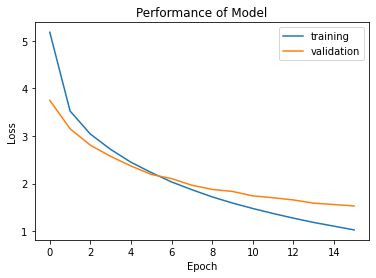

In [44]:
#TODO : Plot the train and validation losses on the same graph.
plt.plot(range(NUM_EPOCHS), train_losses, label="training")
plt.plot(range(NUM_EPOCHS), val_losses, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model")
plt.legend()
plt.show()

### 5.8 Transformer evaluation

In [45]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
          break
    return ys


def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
  model.eval()
  src_stoi = src_vocab.get_stoi()
  tokens = [BOS_IDX] + [src_stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
  tgt_itos = tgt_vocab.get_itos()

  # print("=", " ".join([tgt_itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", ""))
  return " ".join([tgt_itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [92]:
# TODO: run the function translate on 15 examples from the test. Print the src and the tgt sentences
from numpy.random import default_rng
N_EXPLS = 15

# Sampling 15 examples from test
rng = default_rng()
rand_idxs = rng.choice(len(pairs_test), size=N_EXPLS, replace=False)
test_sample = [pairs_test[i] for i in rand_idxs]

predictions = []
for fr_test, en_test in test_sample:
    fr_pred = translate(
                  transformer, 
                  en_test, 
                  src_vocab=SRC_VOCAB, 
                  tgt_vocab= TGT_VOCAB, 
                  src_tokenizer=en_tokenizer)
    predictions.append(fr_pred)
    print(f"~~ SRC`{en_test}` ?...\n...({fr_pred}) : TGT(`{fr_test}`)")

### Get blue score

In [112]:
def evaluate_transformer_all_blue_score(model, pairs, src_vocab, tgt_vocab, src_tokenizer):
    # TODO
    _1gm = 0
    _2gm = 0
    _3gm = 0
    _4gm = 0

    for fr_test, en_test in pairs:
        fr_pred = translate(
                      model, 
                      en_test, 
                      src_vocab=SRC_VOCAB, 
                      tgt_vocab= TGT_VOCAB, 
                      src_tokenizer=src_tokenizer
                    )
        
        print(f"~~\n SRC(`{en_test}`) ?...\n...({fr_pred}) : TGT(`{fr_test}`)")
        prediction = fr_pred.strip().split(' ')
        target = [fr_test.strip().split(' ')]

        _1gm += sentence_bleu(target, prediction, weights=(1, 0, 0, 0))
        _2gm += sentence_bleu(target, prediction, weights=(0.5, 0.5, 0, 0))
        _3gm += sentence_bleu(target, prediction, weights=(0.33, 0.33, 0.33, 0))
        _4gm += sentence_bleu(target, prediction, weights=(0.25, 0.25, 0.25, 0.25))
        print(f"Score: {sentence_bleu(target,prediction):.3f}")
    print("\n\nSCORE")
    print(f"""The cumulative BLUE score on the test set is : 
    BLUE-1:{_1gm/len(pairs)}
    BLUE-2:{_2gm/len(pairs)}
    BLUE-3:{_3gm/len(pairs)}
    BLUE-4:{_4gm/len(pairs)}
    """)


In [114]:
 # TODO: Call evaluate_transformer_all_blue_score on your the set.
evaluate_transformer_all_blue_score(
                                  transformer, 
                                  test_sample, 
                                  SRC_VOCAB, 
                                  TGT_VOCAB, 
                                  en_tokenizer
                                )


~~
 SRC(`i m sorry if i frightened you .`) ?...
...( je suis desole si je vous ai derange . ) : TGT(`je suis desole si je t ai effraye .`)
Score: 0.485
~~
 SRC(`you are very dear to me .`) ?...
...( tu es tres en train de me faire moi . ) : TGT(`tu es mon obsession .`)
Score: 0.000
~~
 SRC(`we re reading .`) ?...
...( nous sommes en train de lire . ) : TGT(`nous sommes en train de lire .`)
Score: 1.000
~~
 SRC(`you re big .`) ?...
...( tu es grande . ) : TGT(`vous etes grandes .`)
Score: 0.000
~~
 SRC(`we re not eating .`) ?...
...( nous ne sommes pas en train de manger . ) : TGT(`nous ne sommes pas en train de manger .`)
Score: 1.000
~~
 SRC(`we re satisfied .`) ?...
...( nous sommes satisfait . ) : TGT(`nous sommes satisfaits .`)
Score: 0.000
~~
 SRC(`i m doing this for you .`) ?...
...( je le fais pour toi . ) : TGT(`je le fais pour vous .`)
Score: 0.537
~~
 SRC(`you re very funny .`) ?...
...( vous etes tres drole . ) : TGT(`vous etes fort drole .`)
Score: 0.000
~~
 SRC(`i m freezi

### 5.9 Conclusion

**TODO** : Write a conclusion comparing your expericence with a RNN and a Transformer.

##6. Références

[1] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and Illia Polosukhin. Attention is all you need. [arXiv preprint arXiv :1706.03762, 2017.](https://arxiv.org/pdf/1706.03762.pdf)

[2] Salman Khan, Muzammal Naseer, Munawar Hayat, Syed Waqas Zamir, Fahad Shahbaz Khan, and Mubarak Shah. Transformers in vision : A survey. [arXiv preprint arXiv :2101.01169, 2021.](https://arxiv.org/pdf/2101.01169.pdf)

[3] Kai Han, Yunhe Wang, Hanting Chen, Xinghao Chen, Jianyuan Guo, Zhenhua Liu, Yehui Tang, An Xiao, Chunjing Xu, Yixing Xu, et al. A survey on visual transformer. [arXiv preprint arXiv :2012.12556, 2020.](https://arxiv.org/pdf/2012.12556.pdf)